# Problema
El problema consiste en separar una serie de números en dos grupos de forma que ambos sumen lo mismo.

# Ising

Si consideramos el uso de spins 1 y -1 se puede considerar en la forma:
$n_0*s_0+n_1*s_1...n_n*s_n$

Agrupando los elementos con spin 1 y los de spin -1, de esta forma se trataría de acercar esa suma a 0. 
Esto lo podemos representar de la siguiente forma para convertirlo en un problema de minimización:

$(\sum_{i=1}^{n}n_is_i)^2$

Aunque también podríamos utilizar el valor absoluto en lugar del cuadrado: 

$|\sum_{i=1}^{n}n_is_i|$

En cualquiera de los casos será mínimo cuando el sumatorio tienda a 0 que será cuando ambos grupos tengan el mismo valor. Para este ejercicio utilizaremos el primero.


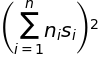

In [ ]:
from sympy import init_printing, Symbol, expand, summation
from sympy import *

init_printing()
s1 = Symbol('s_1')#s0
s2 = Symbol('s_2')#s1
s3 = Symbol('s_3')#s2
s4 = Symbol('s_4')#s3
n1= Symbol('n_1')
n2= Symbol('n_2')
n3= Symbol('n_3')
n4= Symbol('n_4')
ni= Symbol ('n_i')
si= Symbol ('s_i')
i= Symbol('i')
n = Symbol('n')
h0=(Sum(ni*si,(i,1,n)))**2

display(h0)



Pongamos que queremos resolver el problema para un ejemplo sencillo como (1,2,3,4). Primero vamos a expandir el sumatorio para cuatro números cualesquiera $n_i$:

In [ ]:
h1=(s1*n1+n2*s2+n3*s3+n4*s4)**2
display(h1)
h2=h1.expand()
print()
display(h2)

Ahora vamos a especificarlo para nuestro problema concreto:

In [ ]:
display(h2.subs({n1:1,n2:2,n3:3,n4:4}))

De ahí sacamos los valores para $J_{ij}$ que son $n_in_j$.

# QUBO

Otra forma de afrontar el problema es con QUBO en lugar de Ising, en este caso los valores para cada subconjunto serían 0 o 1 en lugar de un spin -1, 1. De esta forma la suma de los elementos pertenecientes al subset del 1 sería $\sum_{i=1}^{n}n_ix_i$ y la suma del subset del 0 sería la diferencia entre el sumatorio total y el del 1: $\sum_{i=1}^{n}n_i-\sum_{i=1}^{n}n_ix_i$

La diferencia entre las sumas es por tanto $\sum_{i=1}^{n}n_i-2\sum_{i=1}^{n}n_ix_i$


Si consideramos el sumatorio de todos los elementos como c: $c-2\sum_{i=1}^{n}n_ix_i$ 

Para minimizar esta diferencia minimizamos su cuadrado como en el caso de Ising

$diff^2=(c-2\sum_{i=1}^{n}n_ix_i)^2=c^2+4x^tQ_x$

Con la matriz Q construida con: $q_{ii}=n_i(n_i-c)$   y   $q_{ij}=n_in_j$

Quitando las constantes el problema de minimización se queda con la forma $x^tQx$ con la matriz $Q$ contruida de la forma ya mencionada.

# Código y ejecución

 Vamos a comenzar con dimod, generaremos los valores tanto de $J$ y $h$ para Ising como de $Q$ para QUBO aunque la creación del modelo con QUBO quedará comentada y el código se ejecutará con Ising, en cualquier caso se pueden intercambiar los comentarios y utilizar QUBO indistintamente.

In [1]:
!pip install dwave-ocean-sdk

     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 399kB 13.9MB/s 
     |████████████████████████████████| 798kB 19.1MB/s 
     |████████████████████████████████| 204kB 39.3MB/s 
     |████████████████████████████████| 788kB 37.4MB/s 
     |████████████████████████████████| 7.0MB 21.4MB/s 
     |████████████████████████████████| 3.3MB 37.6MB/s 
     |████████████████████████████████| 409kB 43.6MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
     |████████████████████████████████| 14.2MB 292kB/s 
     |████████████████████████████████| 1.0MB 25.9MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [1]:
!dwave setup

Optionally install non-open-source packages and configure your environment.

Do you want to select non-open-source packages to install (y/n)? [y]: n

Creating the D-Wave configuration file.
Configuration file not found; the default location is: /root/.config/dwave/dwave.conf
Configuration file path [/root/.config/dwave/dwave.conf]: 
Configuration file path does not exist. Create it? [y/N]: y
Profile (create new) [prod]: 
API endpoint URL [skip]: https://cloud.dwavesys.com/sapi/
Authentication token [skip]: DEV-8a8b590fb1a50eda5d555879002f08ed816c82a0
Default client class [skip]: 
Default solver [skip]: 
Configuration saved.


Una vez instalado y configurado (si queremos utilizar los annealers) preparamos los datos del problema con dos diccionarios para $J$ y $h$ y un listado de números.

In [18]:
import numpy as np
import dimod
from dimod.reference.samplers import ExactSolver
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
J = {}
h = {}
Q= {}
values=[2,4,3,1]
#values=[2,7,16,25,14,3,8,4,21,43,16,1]

A continuación generamos los valores de $J$ y $Q$ de la forma mencionada anteriormente ($h$ no contiene ningún elemento en nuestro caso)

In [19]:
c=0
for value in values:
  c+=value
i=0
j=0
while i < len(values):
    while j<len(values):
        if i==j:
            Q[(i,j)]=values[i]*(values[i]-c)
        else:
            Q[(i,j)]=values[i]*values[j]
        J[(i,j)]=values[i]*values[j]
        j+=1
    i+=1
    j=0
i=0
j=0

Y los cargamos en el modelo

In [25]:
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
#model = dimod.BinaryQuadraticModel.from_qubo(Q)
print("The model we are going to solve in BinaryQuadratic is")
print(model)
print()



The model we are going to solve in BinaryQuadratic is
BinaryQuadraticModel({0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}, {(0, 1): 16, (0, 2): 12, (0, 3): 4, (1, 2): 24, (1, 3): 8, (2, 3): 6}, 30.0, 'SPIN')



Primero lo ejecutamos con el exact solver:

In [26]:
sampler = ExactSolver()
solution = sampler.sample(model)
print("The exact solution is ")
print(solution)
print()

The exact solution is 
    0  1  2  3 energy num_oc.
6  +1 -1 +1 -1    0.0       1
12 -1 +1 -1 +1    0.0       1
2  +1 +1 -1 -1    4.0       1
3  -1 +1 -1 -1    4.0       1
8  -1 -1 +1 +1    4.0       1
9  +1 -1 +1 +1    4.0       1
4  -1 +1 +1 -1   16.0       1
7  -1 -1 +1 -1   16.0       1
13 +1 +1 -1 +1   16.0       1
14 +1 -1 -1 +1   16.0       1
1  +1 -1 -1 -1   36.0       1
11 -1 +1 +1 +1   36.0       1
5  +1 +1 +1 -1   64.0       1
15 -1 -1 -1 +1   64.0       1
0  -1 -1 -1 -1  100.0       1
10 +1 +1 +1 +1  100.0       1
['SPIN', 16 rows, 16 samples, 4 variables]



Con simulated annealing

In [27]:
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
print("La solucion con simulated annealing es")
print(response)

La solucion con simulated annealing es
   0  1  2  3 energy num_oc.
0 -1 +1 -1 +1    0.0       1
1 -1 +1 -1 +1    0.0       1
2 -1 +1 -1 +1    0.0       1
3 +1 -1 +1 -1    0.0       1
4 +1 -1 +1 -1    0.0       1
5 +1 -1 +1 -1    0.0       1
6 -1 +1 -1 +1    0.0       1
7 +1 -1 +1 -1    0.0       1
8 +1 -1 +1 -1    0.0       1
9 -1 +1 -1 +1    0.0       1
['SPIN', 10 rows, 10 samples, 4 variables]


Y ahora con un annealer (requiere tener el setup realizado):

In [28]:
sampler = EmbeddingComposite(DWaveSampler(solver='Advantage_system1.1'))
sampler_name = sampler.properties['child_properties']['chip_id']
response = sampler.sample(model, num_reads=5000)
print("The solution with D-Wave's quantum annealer called ",sampler_name,"en")
print(response)

The solution with D-Wave's quantum annealer called  Advantage_system1.1 en
    0  1  2  3 energy num_oc. chain_.
0  +1 -1 +1 -1    0.0     957     0.0
1  -1 +1 -1 +1    0.0    1698     0.0
2  -1 +1 -1 -1    4.0     674     0.0
3  -1 -1 +1 +1    4.0     736     0.0
4  +1 +1 -1 -1    4.0     469     0.0
5  +1 -1 +1 +1    4.0     355     0.0
6  -1 -1 +1 -1   16.0      28     0.0
7  +1 +1 -1 +1   16.0      19     0.0
8  +1 -1 -1 +1   16.0      21     0.0
9  -1 +1 +1 -1   16.0      42     0.0
10 +1 -1 -1 -1   36.0       1     0.0
['SPIN', 11 rows, 5000 samples, 4 variables]


Y con otro:

In [29]:
sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_6'))
sampler_name = sampler.properties['child_properties']['chip_id']
response = sampler.sample(model, num_reads=5000)
print("The solution with D-Wave's quantum annealer called ",sampler_name,"en")
print(response)
print()

The solution with D-Wave's quantum annealer called  DW_2000Q_6 en
    0  1  2  3 energy num_oc. chain_.
0  -1 +1 -1 +1    0.0    1567     0.0
1  +1 -1 +1 -1    0.0    1505     0.0
2  -1 +1 -1 -1    4.0     558     0.0
3  -1 -1 +1 +1    4.0     469     0.0
4  +1 -1 +1 +1    4.0     462     0.0
5  +1 +1 -1 -1    4.0     393     0.0
6  -1 +1 +1 -1   16.0       8     0.0
7  +1 -1 -1 +1   16.0      18     0.0
8  +1 +1 -1 +1   16.0      11     0.0
9  -1 -1 +1 -1   16.0       7     0.0
10 +1 -1 -1 -1   36.0       1     0.0
11 -1 -1 -1 +1   64.0       1     0.0
['SPIN', 12 rows, 5000 samples, 4 variables]



Esta notebook y el código en python para el Dwave IDE están disponibles en https://github.com/uo720/NumberPartitioningDwave